## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [4]:
# Load the data
h5f = h5py.File('data/data_cano_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3011, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [5]:
from models import Squeeze_model

In [6]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [8]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs =200
l_rate = 1e-4

In [9]:
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [10]:
aug_data_gen = AugmentedDataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
aug_val_gen = AugmentedDataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [11]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(288, 24, 24, 24, 16) (288,)


In [12]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-cano_rotated_90.h5"

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [13]:
history = model.fit_generator(generator=aug_data_gen, validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=5, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/200
250/250 [==============================] - 191s 763ms/step - loss: 1.9827 - val_loss: 1.4836

Epoch 00001: val_loss improved from inf to 1.48365, saving model to ./weights/weights-cano_rotated_90.h5
Epoch 2/200
250/250 [==============================] - 306s 1s/step - loss: 1.6614 - val_loss: 1.4661

Epoch 00002: val_loss improved from 1.48365 to 1.46606, saving model to ./weights/weights-cano_rotated_90.h5
Epoch 3/200
250/250 [==============================] - 512s 2s/step - loss: 1.5060 - val_loss: 1.4792

Epoch 00003: val_loss did not improve from 1.46606
Epoch 4/200
250/250 [==============================] - 653s 3s/step - loss: 1.4930 - val_loss: 1.7165

Epoch 00004: val_loss did not improve from 1.46606
Epoch 5/200
250/250 [==============================] - 720s 3s/step - loss: 1.5646 - val_loss: 1.3234

Epoch 00005: val_loss improved from 1.46606 to 1.32341, saving model to ./weights/weights-cano_rotated_90.h5
Epoch 6/200
250/250 [==============================] - 79

250/250 [==============================] - 1520s 6s/step - loss: 0.8540 - val_loss: 1.4335

Epoch 00051: val_loss did not improve from 1.19199
Epoch 52/200
250/250 [==============================] - 1448s 6s/step - loss: 0.8475 - val_loss: 1.2747

Epoch 00052: val_loss did not improve from 1.19199
Epoch 53/200
250/250 [==============================] - 1482s 6s/step - loss: 0.8469 - val_loss: 1.4311

Epoch 00053: val_loss did not improve from 1.19199
Epoch 54/200
250/250 [==============================] - 1499s 6s/step - loss: 0.7764 - val_loss: 1.3975

Epoch 00054: val_loss did not improve from 1.19199
Epoch 55/200
250/250 [==============================] - 1501s 6s/step - loss: 0.7497 - val_loss: 1.3796

Epoch 00055: val_loss did not improve from 1.19199
Epoch 56/200
250/250 [==============================] - 1456s 6s/step - loss: 0.7271 - val_loss: 1.4307

Epoch 00056: val_loss did not improve from 1.19199
Epoch 57/200
250/250 [==============================] - 1499s 6s/step - loss:


Epoch 00103: val_loss did not improve from 1.19199
Epoch 104/200
250/250 [==============================] - 1567s 6s/step - loss: 0.2904 - val_loss: 1.5245

Epoch 00104: val_loss did not improve from 1.19199
Epoch 105/200
250/250 [==============================] - 1547s 6s/step - loss: 0.2893 - val_loss: 1.5316

Epoch 00105: val_loss did not improve from 1.19199
Epoch 106/200
250/250 [==============================] - 1577s 6s/step - loss: 0.2843 - val_loss: 1.5598

Epoch 00106: val_loss did not improve from 1.19199
Epoch 107/200
250/250 [==============================] - 1601s 6s/step - loss: 0.2770 - val_loss: 1.5740

Epoch 00107: val_loss did not improve from 1.19199
Epoch 108/200
250/250 [==============================] - 1515s 6s/step - loss: 0.2643 - val_loss: 1.5893

Epoch 00108: val_loss did not improve from 1.19199
Epoch 109/200
250/250 [==============================] - 1619s 6s/step - loss: 0.2649 - val_loss: 1.5214

Epoch 00109: val_loss did not improve from 1.19199
Epoch 

250/250 [==============================] - 1280s 5s/step - loss: 0.2025 - val_loss: 1.5705

Epoch 00156: val_loss did not improve from 1.19199
Epoch 157/200
250/250 [==============================] - 1331s 5s/step - loss: 0.2037 - val_loss: 1.4722

Epoch 00157: val_loss did not improve from 1.19199
Epoch 158/200
250/250 [==============================] - 1367s 5s/step - loss: 0.1988 - val_loss: 1.5979

Epoch 00158: val_loss did not improve from 1.19199
Epoch 159/200
250/250 [==============================] - 1345s 5s/step - loss: 0.1922 - val_loss: 1.4894

Epoch 00159: val_loss did not improve from 1.19199
Epoch 160/200
250/250 [==============================] - 1400s 6s/step - loss: 0.1882 - val_loss: 1.4682

Epoch 00160: val_loss did not improve from 1.19199
Epoch 161/200
250/250 [==============================] - 1373s 5s/step - loss: 0.1934 - val_loss: 1.5158

Epoch 00161: val_loss did not improve from 1.19199
Epoch 162/200
250/250 [==============================] - 1389s 6s/step -

In [14]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_cano_rotated_90.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

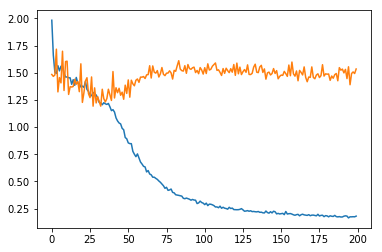

In [15]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [16]:
# Save the weights
# model.save_weights('weights/weights_cano_rotated_90.h5')

In [17]:
model.load_weights(filepath)

In [18]:
from sklearn.metrics import r2_score

In [19]:
sample_size = 200
rotation_count = 24

train_aug_data_gen = AugmentedDataGenerator(x=train_x,
                                            y=train_y,
                                            batch_size=sample_size)
# Two chunks to avoid memory issues
test_aug_data_gen= AugmentedDataGenerator(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size)

# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*rotation_count
        end = i*rotation_count + rotation_count
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break
    
#sample_size = test_x.shape[0]
    
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*rotation_count
        end = i*rotation_count + rotation_count
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Train r2 (without average):  0.307840780391
Train r2 (with average):  0.32078708343
Test r2 (without average):  0.282230810852
Test r2 (with average):  0.299208166347
